# 뉴스 그룹 분류 경진대회

`-` 참고: https://dacon.io/competitions/official/235884/codeshare/4739?page=1&dtype=recent

`-` 참고: https://dacon.io/competitions/official/235864/codeshare/4246?page=1&dtype=recent

## 패키지 import및 데이터 전치리

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
# nltk.download('all')

In [2]:
SEED = 22

In [3]:
os.chdir('C:\\Users\\Jaesu\\github_desktop\\Dacon-Basic\\뉴스-그룹-분류')

In [4]:
df = pd.read_csv('./Data/train.csv')
test = pd.read_csv('./Data/test.csv')
submission = pd.read_csv('./Data/sample_submission.csv')

In [5]:
def clean_text(texts): 
    corpus = [] 
    for i in range(0, len(texts)): 
        review = re.sub(r'[@%\\*=()/~#&\+á?\xc3\xa1\-\|\.\:\;\!\-\,\_\~\$\'\"\n\]\[\>]', '', texts[i]) ## @%*=()/+ 와 같은 문장부호 제거
        #review = re.sub(r'\d+','', review) ## 숫자 제거
        review = review.lower() ## 소문자 변환
        review = re.sub(r'\s+', ' ', review) ## extra space 제거
        review = re.sub(r'<[^>]+>','',review) ## Html tags 제거
        review = re.sub(r'\s+', ' ', review) ## spaces 제거
        review = re.sub(r"^\s+", '', review) ## space from start 제거
        review = re.sub(r'\s+$', '', review) ## space from the end 제거
        review = re.sub(r'_', ' ', review) ## space from the end 제거
        corpus.append(review) 

    return corpus

In [6]:
df['clean_text'] = clean_text(df['text'])
test['clean_text'] = clean_text(test['text'])

In [7]:
def remove_stopwords(df_text, stopwords_list):
    df_words = df_text.split()
    df_text_without_stopwords  = ' '.join([df_word for df_word in df_words if df_word not in stopwords_list])
    return df_text_without_stopwords

In [8]:
stopwords_list = stopwords.words('english') ## nltk에서 제공하는 불용어사전 이용

In [9]:
df['clean_text'] = df['clean_text'].apply(lambda text: remove_stopwords(text, stopwords_list))
test['clean_text'] = test['clean_text'].apply(lambda text: remove_stopwords(text, stopwords_list))

In [10]:
df['text_without_stopwords'] = df['text'].apply(lambda text: remove_stopwords(text, stopwords_list))
test['text_without_stopwords'] = test['text'].apply(lambda text: remove_stopwords(text, stopwords_list))

## 스태킹 (Stacking)

In [180]:
import rich 
from rich.table import Table

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_validate
from sklearn.naive_bayes import ComplementNB
from sklearn.linear_model import SGDClassifier, LogisticRegression 
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

In [214]:
## accuracy 계산
def accuracy(true, pred):
    return sum(true == pred) / len(true)

In [215]:
def get_pipe(model, model_name: str) -> Pipeline:
    """TfidfVectorizer와 모델을 연결한 파이프라인을 반환하는 함수"""
    tfidf = TfidfVectorizer(analyzer='char', ngram_range=(1, 3))
    pipe = Pipeline([
        ('tfidf', tfidf),
        (model_name, model)
    ])
    return pipe

In [216]:
def get_kfold_accuarcy(model, k: int = 5) -> float:
    """모델을 입력받아 KFold 예측 후 accuracy score를 반환하는 함수"""
    skfold = StratifiedKFold(k, shuffle=True, random_state=SEED)
    acc_list = []
    for train_idx, valid_idx in skfold.split(df['clean_text'], df['target']):
        print('training......')
        train, valid = df.iloc[train_idx], df.iloc[valid_idx]
        model.fit(train['clean_text'], train['target'])
        pred = model.predict(valid['clean_text'])
        acc = accuracy(valid['target'], pred)
        acc_list.append(acc)

    return np.mean(acc_list)

In [25]:
models = [
    ('SGD', SGDClassifier(random_state=SEED, n_jobs=-1)),
    ('rfc', RandomForestClassifier(random_state=SEED, min_samples_split=10, n_jobs=-1)),
    ('logistic', LogisticRegression(random_state=SEED, max_iter=500)),
]

In [20]:
model_pipes = [(model_name, get_pipe(model, model_name)) for model_name, model in models]

`-` 부스팅 모델(xgboost, lgbm, catboost)을 쓰면 너무너무 느리다...(에러가 나는건 아닌데 무한 로딩 걸림)

`-` 생각해보니 학습할 파라미터 수가 너무 많다

In [21]:
table = Table(title='Model Comparison Table')
table.add_column('Model Name', justify='left', style='green')
table.add_column('Accuracy', justify='right')

for model_name, model in tqdm(model_pipes, leave=False):
    acc = get_kfold_accuarcy(model)
    table.add_row(model_name, f'{acc:0.4f}')

rich.print(table)

 Model Comparison Table  
┏━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Model Name ┃ Accuracy ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━┩
│ SGD        │   0.6663 │
│ rfc        │   0.5498 │
│ logistic   │   0.6173 │
└────────────┴──────────┘

In [24]:
from sklearn.ensemble import StackingClassifier

stack_models = [(model_name, get_pipe(model, model_name)) for model_name, model in models]
stacking = StackingClassifier(stack_models)
acc = get_kfold_accuarcy(stacking)
rich.print(acc)

training......


C:\anaconda3\envs\py38r40\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


training......


C:\anaconda3\envs\py38r40\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


training......


C:\anaconda3\envs\py38r40\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


training......


C:\anaconda3\envs\py38r40\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


training......


C:\anaconda3\envs\py38r40\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.6683616253348671

In [26]:
stacking.fit(df['clean_text'], df['target'])
pred = stacking.predict(test['clean_text'])

C:\anaconda3\envs\py38r40\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [27]:
submission['target'] = pred
submission.head()

,id,target
0,0,3
1,1,16
2,2,11
3,3,8
4,4,7


In [28]:
submission.to_csv('./Data/submission2.csv', index=False)

`-` 점수는 0.6681109185

## 단일 모델

In [181]:
count_vec = CountVectorizer()

In [182]:
train_vec = count_vec.fit_transform(df['text_without_stopwords'])
test_vec = count_vec.transform(test['text_without_stopwords'])

`-` CountVectorizer는 성능이 별로였다

In [99]:
tfidf1 = TfidfVectorizer(ngram_range=(1, 1), stop_words='english')
tfidf = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
tfidf2 = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
tfidf3 = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
tfidf4 = TfidfVectorizer(ngram_range=(1, 3), stop_words='english')

In [100]:
tfidf1.fit(np.array(df['text_without_stopwords']))
tfidf.fit(np.array(df['text']))
tfidf2.fit(np.array(df['text_without_stopwords']))
tfidf3.fit(np.array(df['clean_text']))
tfidf4.fit(np.array(df['text_without_stopwords']))

TfidfVectorizer(stop_words='english')

In [101]:
train_tfidf1 = tfidf1.transform(df['text_without_stopwords'])
test_tfidf1 = tfidf1.transform(test['text_without_stopwords'])

train_tfidf = tfidf.transform(df['text'])
test_tfidf = tfidf.transform(test['text'])

train_tfidf2 = tfidf2.transform(df['text_without_stopwords'])
test_tfidf2 = tfidf2.transform(test['text_without_stopwords'])

train_tfidf3 = tfidf3.transform(df['clean_text'])
test_tfidf3 = tfidf3.transform(test['clean_text'])

train_tfidf4 = tfidf4.transform(df['text_without_stopwords'])
test_tfidf4 = tfidf4.transform(test['text_without_stopwords'])

In [19]:
target = df['target']

In [20]:
k = 5
skfold = StratifiedKFold(k, shuffle=True, random_state=SEED)

In [21]:
#X_train, X_valid, y_train, y_valid = train_test_split(train_tfidf, target, train_size=0.8, test_size=0.2, random_state=SEED, stratify=target)

`-` LSVC에서 C에 따른 정확도 시각화

In [36]:
train_kfold_acc_list, valid_kfold_acc_list = [], []
C = [0.1, 0.5, 1, 3, 5, 7, 10] ## C

for c in tqdm(C):
    LSVC = LinearSVC(random_state=SEED, C=c)
    scores = cross_validate(LSVC, train_tfidf, target, scoring = ('accuracy'),
                            return_train_score = True, cv = skfold)

    train_kfold_acc_list.append(np.mean(scores['train_score'])) ## acc
    valid_kfold_acc_list.append(np.mean(scores['test_score']))  ## acc

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [09:21<00:00, 80.20s/it]


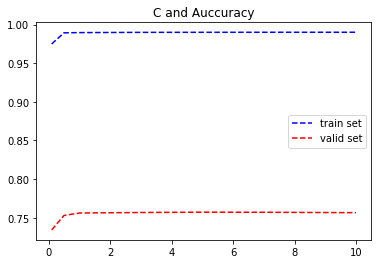

In [37]:
plt.plot(C, train_kfold_acc_list, 'b--', label = 'train set')
plt.plot(C, valid_kfold_acc_list, 'r--', label = 'valid set')
plt.title('C and Auccuracy')
plt.legend()

`-` C가 5일 때 정확도가 제일 높다

`-` 텍스트 전처리에 따른 모델별 정확도 

In [163]:
SGD = SGDClassifier(random_state=SEED, n_jobs=-1)
LSVC = LinearSVC(random_state=SEED, C=5)
CNB = ComplementNB(alpha=0.2)

`-` `ngram_range = (1, 2)`

In [57]:
scores_LSVC = cross_validate(LSVC, train_tfidf, target, scoring = ('accuracy'), cv = skfold)
scores2_LSVC = cross_validate(LSVC, train_tfidf2, target, scoring = ('accuracy'), cv = skfold)
scores3_LSVC = cross_validate(LSVC, train_tfidf3, target, scoring = ('accuracy'), cv = skfold)

scores_SGD = cross_validate(SGD, train_tfidf, target, scoring = ('accuracy'), cv = skfold)
scores2_SGD = cross_validate(SGD, train_tfidf2, target, scoring = ('accuracy'), cv = skfold)
scores3_SGD = cross_validate(SGD, train_tfidf3, target, scoring = ('accuracy'), cv = skfold)

In [58]:
print(f"tfidf1 -> LSVC: {np.mean(scores_LSVC['test_score'])} SGD: {np.mean(scores_SGD['test_score'])}")
print(f"tfidf2 -> LSVC: {np.mean(scores2_LSVC['test_score'])} SGD: {np.mean(scores2_SGD['test_score'])}")
print(f"tfidf3 -> LSVC: {np.mean(scores3_LSVC['test_score'])} SGD: {np.mean(scores3_SGD['test_score'])}")

tfidf1 -> LSVC: 0.7571752031492609 SGD: 0.7552260378312521
tfidf2 -> LSVC: 0.7572838388039285 SGD: 0.7573925331171569
tfidf3 -> LSVC: 0.7239241873296336 SGD: 0.7223000490972153


In [161]:
scores_CNB = cross_validate(CNB, train_tfidf, target, scoring = ('accuracy'), cv = skfold)
scores2_CNB = cross_validate(CNB, train_tfidf2, target, scoring = ('accuracy'), cv = skfold)

In [159]:
print(f"tfidf -> CNB: {np.mean(scores_CNB['test_score'])}")
print(f"tfidf2 -> CNB: {np.mean(scores2_CNB['test_score'])}")

tfidf -> CNB: 0.7784029150958393
tfidf2 -> CNB: 0.7786200104294921


`-` `ngram_range = (1, 3)`

In [69]:
scores4_SGD = cross_validate(SGD, train_tfidf4, target, scoring = ('accuracy'), cv = skfold)

In [70]:
print(f"tfidf4 -> SGD: {np.mean(scores2_SGD['test_score'])}")

tfidf4 -> SGD: 0.7573925331171569


`-` 신기하게도 텍스트에 전처리를 하면 정학도가 오히려 떨어진다

`-` 전체 데이터로 다시 학습

In [171]:
LSVC.fit(train_tfidf2, target)
SGD.fit(train_tfidf2, target)
CNB.fit(train_tfidf2, target)

ComplementNB(alpha=0.2)

In [172]:
pred1 = SGD.predict(test_tfidf2)
pred2 = LSVC.predict(test_tfidf2)
pred3 = CNB.predict(test_tfidf2)

In [299]:
submission['target'] = pred1
submission.head()

,id,target
0,0,3
1,1,16
2,2,11
3,3,8
4,4,13


In [297]:
submission.to_csv('./Data/submission_SGD.csv', index=False)

In [300]:
submission['target'] = pred2
submission.to_csv('./Data/submission_LSVC.csv', index=False)

In [177]:
submission['target'] = pred3
submission.to_csv('./Data/submission_CNB.csv', index=False)

`-` 점수는 0.78184(CNB, 나머지 둘은 0.25정도 더 낮다)

`-` 단일 모델이 위의 스태킹 모델보다 점수가 훨씬 잘 나왔다

`-` 텍스트를 숫자로 변환하는 방법이 다르고 스태킹에 성능이 낮은 모델이 섞여있어서 그런 것 같다

`-` 근데 텍스트를 숫자로 변환하는 방법의 차이가 영향이 더 큰 것 같다

## TF-IDF + Stacking

In [213]:
def get_pipe2(model, model_name: str) -> Pipeline:
    """TfidfVectorizer와 모델을 연결한 파이프라인을 반환하는 함수"""
    tfidf = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
    pipe = Pipeline([
        ('tfidf', tfidf),
        (model_name, model)
    ])
    return pipe

In [217]:
models = [
    ('SGD', SGDClassifier(random_state=SEED)),
    ('LSVC', LinearSVC(random_state=SEED, C=5.0)),
    ('CNB', ComplementNB(alpha=0.2)),
]

In [218]:
stack_models = [(model_name, get_pipe2(model, model_name)) for model_name, model in models]
stacking = StackingClassifier(stack_models)

In [219]:
stacking.fit(df['text_without_stopwords'], target)
pred = stacking.predict(test['text_without_stopwords'])

C:\anaconda3\envs\py38r40\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [225]:
submission['target'] = pred
submission.head()

,id,target
0,0,3
1,1,16
2,2,11
3,3,8
4,4,12


In [226]:
submission.to_csv('./Data/submission_stacking2.csv', index=False) ## stacking2는 CNB포함, 점수가 똑같음...??
## public에 해당하는 인덱스가 똑같나 보다

## ComplementNB OOF

`-` out-of-fold

In [268]:
CNB = ComplementNB(alpha=0.2)

In [271]:
k = 15
skfold = StratifiedKFold(k, shuffle=True, random_state=SEED)

In [366]:
def OOF_predict(model, X, y, test, score_func, Kfold, is_StratifiedKfold):
    """
    Out-Of-Fold 방식을 통해 test를 예측
    X는 csr_matrix이고 predict_proba 메소드가 있는 model이어야 함
    """
    if is_StratifiedKfold:
        split_fold = Kfold.split(X, y)
    else:
        split_fold = Kfold.split(X)
        
    model_valid_score = []
    model_predict = np.zeros(shape=(X.shape[0], len(y.unique())))

    for train_idx, valid_idx in split_fold:
        X_train, y_train = X[train_idx], y[train_idx]
        X_valid, y_valid = X[valid_idx], y[valid_idx]

        model.fit(X_train, y_train)

        y_predict = model.predict_proba(X_valid).argmax(-1) ## 각 클래스별 확률을 구하고 -1차원을 기준으로 argmax를 구한다(확률이 가장 높은 인덱스 번호를 반환)
        test_predict = model.predict_proba(test)  ## 각 클래스별 확률을 구함

        model_valid_score.append(score_func(y_predict, y_valid)) ## valid 예측값
        model_predict += test_predict / Kfold.n_splits ## test 예측값(k Fold)
        
    model_predict = model_predict.argmax(-1)              
    return model_valid_score, model_predict

`-` 위의 함수를 더 일반화 시키자(ex: 회귀에서도 쓸 수 있게)

In [364]:
CNB_valid_acc, CNB_test_pred = OOF_predict(CNB, train_tfidf2, target, test_tfidf2, accuracy, skfold, True)

In [359]:
submission['target'] = CNB_test_pred
submission.head()

,id,target
0,0,3
1,1,16
2,2,11
3,3,8
4,4,7


In [317]:
submission.to_csv('./Data/submission_CNB-OOF.csv', index=False)